In [2]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

In [20]:
n_features = 13
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
#     mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_features).T
    melspec = librosa.feature.melspectrogram(y=X, sr=sample_rate).T
    result = melspec
    return result

In [19]:
wav_file = './discharge-detection/training-data/train_000002.wav'
smallest_wav_file = './discharge-detection/training-data/train_004947.wav'
y, sr = librosa.load(smallest_wav_file)
librosa.get_duration(y=y, sr=sr)
librosa.feature.melspectrogram(y, sr=sr).T.shape

(10, 128)

In [5]:
def get_file_duration(file_name):
    y, sr = librosa.load(file_name)
    return librosa.get_duration(y=y, sr=sr)

In [22]:
training_folder = './discharge-detection/training-data/'

files = list(glob.glob('{}/*.wav'.format(training_folder)))
file_durations = []
for fn in files:
    file_durations.append(get_file_duration(fn))
print(len(file_durations))

8523


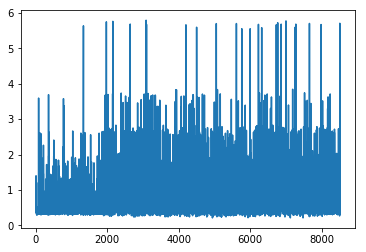

In [23]:
plt.plot(file_durations)

In [6]:
import seaborn as sns
sns.distplot(file_durations)

ImportError: No module named 'seaborn'

In [7]:
import sklearn
import scipy

In [25]:
print(np.amin(file_durations))
print(np.amax(file_durations))

0.20970521542
5.79337868481


In [16]:
test_folder = './discharge-detection/test-data/'

test_files = list(glob.glob('{}/*.wav'.format(test_folder)))
test_file_durations = []
for fn in test_files:
    test_file_durations.append(get_file_duration(fn))
print(len(test_file_durations))

5137


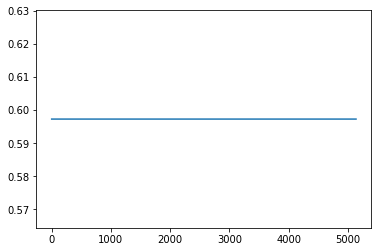

In [17]:
plt.plot(test_file_durations)

In [8]:
def parse_audio_file(filename, label):
    features = extract_feature(filename)
    labels = np.full((np.size(features, 0)), label)
    return features, labels

In [9]:
extract_feature('./discharge-detection/training-data/train_004790.wav').shape

(11, 13)

In [10]:
feature = extract_feature('./discharge-detection/training-data/train_004790.wav')
min_height = 10
height = feature.shape[0]
for i in range(0, height - min_height+1):
    print(feature[i:i+min_height, :].shape)

(10, 13)
(10, 13)


In [11]:
import csv
def get_labels(file_name):
    labels = {}
    with open(file_name, 'r') as label_file:
        label_reader = csv.reader(label_file)
        next(label_reader, None)
        for row in label_reader:
            file_name, label = row
            labels[file_name] = int(label)
    return labels
    
train_labels = get_labels('./discharge-detection/training-data/train_labels.csv')

In [12]:
train_labels

{'train_000795.wav': 1,
 'train_001501.wav': 1,
 'train_000151.wav': 1,
 'train_005525.wav': 0,
 'train_000670.wav': 1,
 'train_003503.wav': 0,
 'train_005874.wav': 0,
 'train_000762.wav': 1,
 'train_006460.wav': 0,
 'train_006897.wav': 0,
 'train_004010.wav': 0,
 'train_001503.wav': 1,
 'train_007926.wav': 0,
 'train_006805.wav': 0,
 'train_005584.wav': 0,
 'train_003595.wav': 0,
 'train_001265.wav': 1,
 'train_002659.wav': 0,
 'train_007611.wav': 0,
 'train_003196.wav': 0,
 'train_003103.wav': 0,
 'train_002674.wav': 0,
 'train_004727.wav': 0,
 'train_001078.wav': 1,
 'train_000658.wav': 1,
 'train_002893.wav': 0,
 'train_000953.wav': 1,
 'train_005389.wav': 0,
 'train_002094.wav': 0,
 'train_003381.wav': 0,
 'train_006861.wav': 0,
 'train_004316.wav': 0,
 'train_002788.wav': 0,
 'train_003872.wav': 0,
 'train_006876.wav': 0,
 'train_003920.wav': 0,
 'train_006504.wav': 0,
 'train_008065.wav': 0,
 'train_007235.wav': 0,
 'train_004831.wav': 0,
 'train_006463.wav': 0,
 'train_000804.w

In [13]:
parent_dir = './discharge-detection'
tr_sub_dirs = ["training-data"]
ts_sub_dirs = ["test-data"]

In [28]:
all_features = []
all_labels = []
def parse_audio_files(parent_dir,sub_dirs, file_ext="*.wav"):
    for _, sub_dir in enumerate(sub_dirs):
        print("processing in subdir {}".format(sub_dir))
        file_count = 0
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            file_count += 1
            if file_count % 1000 ==0:
                print("file counts {}...".format(file_count))
            (_, filename) = os.path.split(fn)
            label = train_labels.get(filename, 0)
            features = extract_feature(fn)
            height = features.shape[0]
            for i in range(0, height - min_height + 1):
                ext_features = features[i:i+min_height, :]
                all_features.append(ext_features)
#                 all_labels.append(np.full((np.size(ext_features, 0)), label))
                all_labels.append(label)
parse_audio_files(parent_dir, tr_sub_dirs)
print("done processing files")

processing in subdir training-data
file counts 1000...
file counts 2000...
file counts 3000...
file counts 4000...
file counts 5000...
file counts 6000...
file counts 7000...
file counts 8000...
done processing files


In [29]:
all_features = np.asarray(all_features)
all_labels = np.asarray(all_labels)
all_labels = all_labels.reshape(-1, 1)
print(np.asarray(all_features).shape)
print(np.asarray(all_labels).shape)

(214681, 10, 128)
(214681, 1)


In [40]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, ZeroPadding2D, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import backend as K
K.set_image_dim_ordering('tf')

num_epochs = 10

def training(X_train, y_train, X_test, y_test):
    inputs = Input(shape=all_features.shape, dtype='float32')
    act = 'relu'
    pool_size = 2
    n_batch_size = 50
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding='same', activation=act, input_shape=(10, 128, 1)))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Conv2D(64, (5, 5), padding='same', activation=act))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Flatten())
    model.add(Dense(1000, activation=act))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=n_batch_size, epochs=num_epochs)
    scores = model.evaluate(X_test, y_test, verbose=0)
    return scores[1]*100

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []

for train, test in kfold.split(all_features, all_labels):
    print(train, test)
    break
# X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels)
# X_train = np.expand_dims(X_train, axis=3)

IndexError: too many indices for array

In [36]:
X_train.shape

(161010, 10, 128, 1)

In [39]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, ZeroPadding2D, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import backend as K
K.set_image_dim_ordering('tf')

inputs = Input(shape=all_features.shape, dtype='float32')
act = 'relu'
pool_size = 2
n_batch_size = 50
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', activation=act, input_shape=(10, 128, 1)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Conv2D(64, (5, 5), padding='same', activation=act))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(1000, activation=act))
# model.add(Dense(100, activation=act))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=n_batch_size, epochs=10)

Epoch 1/10
161010/161010 [==============================] - 140s 868us/step - loss: 0.0342 - acc: 0.9940
Epoch 2/10
161010/161010 [==============================] - 165s 1ms/step - loss: 0.0084 - acc: 0.9985
Epoch 3/10
  7100/161010 [>.............................] - ETA: 3:15 - loss: 0.0032 - acc: 0.9992

KeyboardInterrupt: 